# Transformer로 한영 번역기 만들기

In [ ]:
import tensorflow
import numpy
import matplotlib

print(tensorflow.__version__)
print(numpy.__version__)
print(matplotlib.__version__)

In [ ]:
import os
import re
import numpy as np
import sentencepiece as spm
import tensorflow as tf
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

In [ ]:
###  matplotlib 한글 깨짐 해결
np.random.seed(0)

# 한글 지원 폰트
sns.set(font='NanumGothic')
# 마이너스 부호 
plt.rcParams['axes.unicode_minus'] = False

## 2. 필요한 데이터 불러오기

https://github.com/jungyeul/korean-parallel-corpora/tree/master/korean-english-news-v1

In [4]:
import tarfile

# 압축 풀기
train_path = "./data/korean-english-park.train.tar.gz"
test_path = "./data/korean-english-park.test.tar.gz"
dev_path = "./data/korean-english-park.dev.tar.gz"
extract_path = "./data/"

with tarfile.open(train_path, "r:gz") as train:
    train.extractall(path=extract_path)
with tarfile.open(test_path, "r:gz") as test:
    test.extractall(path=extract_path)
with tarfile.open(dev_path, "r:gz") as dev:
    dev.extractall(path=extract_path)

In [5]:
# 파일 경로 설정
train_ko = "./data/korean-english-park.train.ko"
train_en = "./data/korean-english-park.train.en"

# 한국어, 영어 문장을 각각 저장
with open(train_ko, "r", encoding="utf-8") as t_ko, open(train_en, "r", encoding="utf-8") as t_en:
    train_ko_sentences = t_ko.readlines()
    train_en_sentences = t_en.readlines()

# 파일 경로 설정
test_ko = "./data/korean-english-park.test.ko"
test_en = "./data/korean-english-park.test.en"

# 한국어, 영어 문장을 각각 저장
with open(test_ko, "r", encoding="utf-8") as te_ko, open(test_en, "r", encoding="utf-8") as te_en:
    test_ko_sentences = te_ko.readlines()
    test_en_sentences = te_en.readlines()

# 파일 경로 설정
dev_ko = "./data/korean-english-park.dev.ko"
dev_en = "./data/korean-english-park.dev.en"

# 한국어, 영어 문장을 각각 저장
with open(dev_ko, "r", encoding="utf-8") as v_ko, open(dev_en, "r", encoding="utf-8") as v_en:
    dev_ko_sentences = v_ko.readlines()
    dev_en_sentences = v_en.readlines()

In [6]:
train = pd.DataFrame({"ko":train_ko_sentences, "en":train_en_sentences})
test = pd.DataFrame({"ko":test_ko_sentences, "en":test_en_sentences})
dev = pd.DataFrame({"ko":dev_ko_sentences, "en":dev_en_sentences})

In [7]:
cp_train = train.copy()
cp_test = test.copy()
cp_dev = dev.copy()

print(f"훈련 데이터 개수 : {cp_train.shape[0]}")
print(f"검증 데이터 개수 : {cp_dev.shape[0]}")
print(f"테스트 데이터 개수 : {cp_test.shape[0]}")
cp_train.head()

훈련 데이터 개수 : 94123
검증 데이터 개수 : 1000
테스트 데이터 개수 : 2000


ko  \
0             개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"\n   
1  모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하...   
2                       그러나 이것은 또한 책상도 필요로 하지 않는다.\n   
3  79.95달러하는 이 최첨단 무선 광마우스는 허공에서 팔목, 팔, 그외에 어떤 부분...   
4  정보 관리들은 동남 아시아에서의 선박들에 대한 많은 (테러) 계획들이 실패로 돌아갔...   

                                                  en  
0  Much of personal computing is about "can you t...  
1  so a mention a few weeks ago about a rechargea...  
2  Like all optical mice, But it also doesn't nee...  
3  uses gyroscopic sensors to control the cursor ...  
4  Intelligence officials have revealed a spate o...

In [8]:
def preprocess_sentence(sentence):
    sentence = sentence.lower()
    sentence = re.sub(r"[^a-z가-힣0-9.,!?]", " ", sentence)
    sentence = re.sub(r"([.,!?])", r" \1 ", sentence)
    sentence = re.sub(r"\s+", " ", sentence)
    return sentence.strip()

def generate_tokenizer(corpus, model_prefix, vocab_size=20000):
    with open(f"{model_prefix}_corpus.txt", 'w', encoding='utf-8') as f:
        for line in corpus:
            f.write(line + '\n')

    spm.SentencePieceTrainer.train(
        input=f"{model_prefix}_corpus.txt",
        model_prefix=model_prefix,
        vocab_size=vocab_size,
        model_type='bpe',
        pad_id=0, bos_id=1, eos_id=2, unk_id=3
    )

    sp = spm.SentencePieceProcessor()
    sp.load(f"{model_prefix}.model")
    return sp

In [9]:
def tokenize_and_filter(kor, eng, ko_tok, en_tok, max_len=50):
    src, tgt = [], []
    for k, e in zip(kor, eng):
        k_ids = ko_tok.encode(preprocess_sentence(k))
        e_ids = en_tok.encode(preprocess_sentence(e))
        if len(k_ids) <= max_len and len(e_ids) <= max_len:
            src.append(k_ids)
            tgt.append(e_ids)
    return src, tgt

def tf_pad_sequences(seqs, pad_token=0):
    max_len = max(len(s) for s in seqs)
    padded = [s + [pad_token]*(max_len - len(s)) for s in seqs]
    return tf.constant(padded, dtype=tf.int32)

## 5. Transformer 모델 설계

Attention is all you need 논문에 있는 내용들을 바탕으로 내부 모듈부터 Encoder, Decoder 설계를 시작하겠습니다.

### 5.1 Postional Encoding

![image](https://user-images.githubusercontent.com/51338268/148015775-92c1741a-5975-4eff-b6b7-5417aa408536.png)


In [ ]:
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, int(i) / d_model)

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])
    return sinusoid_table

### 5.2 Scaled Dot-Product Attention

![image](https://user-images.githubusercontent.com/51338268/148015901-2b54bcef-99dc-4e8e-b05d-a1a68be45573.png)

![image](https://user-images.githubusercontent.com/51338268/148016159-5c338069-ca87-46fc-b824-c27186abc191.png)

In [ ]:
class ScaledDotAttn(tf.keras.layers.Layer):
    
    def __init__(self, d_model, masked = None):
        super(ScaledDotAttn, self).__init__()
        self.d_model = d_model
        self.masked = masked
        self.query = tf.keras.layers.Dense(d_model)
        self.key = tf.keras.layers.Dense(d_model)
        self.value = tf.keras.layers.Dense(d_model)
        self.softmax = tf.keras.layers.Softmax()
        
    def call(self, x, context_vector = None):
        batch_size = x.shape[0]
        query = self.query(tf.identity(x))
        # encoder-decoder attention
        if context_vector is not None:
            key = self.key(tf.identity(context_vector))
        else:
            key = self.key(tf.identity(x))
        if context_vector is not None:
            value = self.value(tf.identity(context_vector))
        else:
            value = self.value(tf.identity(x))
        
        batch_bucket = []
        for batch in range(batch_size):
            query_key = tf.linalg.matmul(query[batch], tf.transpose(key[batch]))
            scaled_query_key = query_key / np.sqrt(self.d_model)
            
            # masked self-attention
            if self.masked is not None:
                trill_key_query = np.tril(scaled_query_key, 0)
                masked_key_query = np.where(trill_key_query == 0, -1e9, trill_key_query)
                softmax = self.softmax(masked_key_query) # softmax를 하면 masking부분이 0이 됩니다.
            else:
                softmax = self.softmax(scaled_query_key)
            out = tf.linalg.matmul(softmax, value[batch])
            batch_bucket += [out.numpy()]
            
        out = tf.constant(batch_bucket)
        return out

### 5.3 Multi-Head Attention

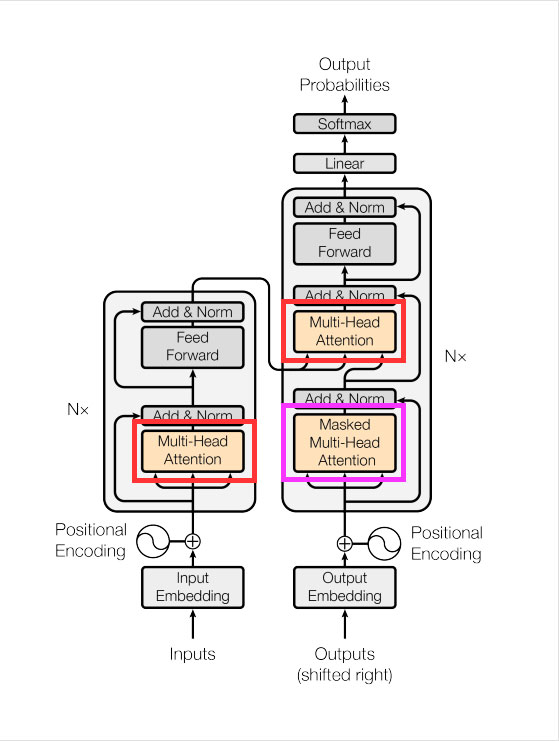

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
            
        self.depth = d_model // self.num_heads
            
        self.W_q = tf.keras.layers.Dense(d_model)
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
            
        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        
        
        """
        Scaled QK 값 구하기
        """
        QK = tf.matmul(Q, K, transpose_b=True)
        scaled_qk = QK / tf.math.sqrt(d_k)
        
        
        if mask is not None: scaled_qk += (mask * -1e9)  
            
            
        """
        1. Attention Weights 값 구하기 -> attentions
        2. Attention 값을 V에 곱하기 -> out
        """ 
        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)

        return out, attentions
            

    def split_heads(self, x):
        """
        Embedding을 Head의 수로 분할하는 함수

        x: [ batch x length x emb ]
        return: [ batch x heads x length x self.depth ]
        """
        batch_size = x.shape[0]
        split_x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])

        return split_x

    def combine_heads(self, x):
        """
        분할된 Embedding을 하나로 결합하는 함수

        x: [ batch x heads x length x self.depth ]
        return: [ batch x length x emb ]
        """
        batch_size = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (batch_size, -1, self.d_model))

        return combined_x

        
    def call(self, Q, K, V, mask):
        """
        아래 순서에 따라 소스를 작성하세요.

        Step 1: Linear_in(Q, K, V) -> WQ, WK, WV
        Step 2: Split Heads(WQ, WK, WV) -> WQ_split, WK_split, WV_split
        Step 3: Scaled Dot Product Attention(WQ_split, WK_split, WV_split)
                 -> out, attention_weights
        Step 4: Combine Heads(out) -> out
        Step 5: Linear_out(out) -> out

        """
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)
        
        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)
            
        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask)
    
        out = self.combine_heads(out)
        out = self.linear(out)
                
        return out, attention_weights

### 5.4 Postion-Wise Feed Forward Network

![image](https://user-images.githubusercontent.com/51338268/148016328-bc152787-a3bb-4f72-9227-458ddb457a0f.png)

In [ ]:
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.w_1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.w_2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.w_1(x)
        out = self.w_2(out)
            
        return out

### 5.5 Encoder

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6) # pre-LN 방식
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):

        """
        Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.dropout(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual
        
        return out, enc_attn

In [ ]:
class Encoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]
        
    def call(self, x, mask):
        out = x
    
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
        
        return out, enc_attns

### 5.6 Decoder

In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
    
    def call(self, x, enc_out, causality_mask, padding_mask):

        """
        Masked Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, causality_mask)
        out = self.dropout(out)
        out += residual

        """
        Multi-Head Attention
        """
        residual = out
        out = self.norm_2(out)
        out, dec_enc_attn = self.enc_dec_attn(out, enc_out, enc_out, padding_mask)
        out = self.dropout(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual

        return out, dec_attn, dec_enc_attn

In [ ]:
class Decoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]
                            
                            
    def call(self, x, enc_out, causality_mask, padding_mask):
        out = x
    
        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, causality_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns

### 5.7 Transformer

In [ ]:
class Transformer(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    src_vocab_size,
                    tgt_vocab_size,
                    pos_len,
                    dropout=0.2,
                    shared=True):
        super(Transformer, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)

        """
        1. Embedding Layer 정의
        2. Positional Encoding 정의
        3. Encoder / Decoder 정의
        4. Output Linear 정의
        5. Shared Weights
        6. Dropout 정의
        """
        self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
        self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.dropout = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared = shared

        if shared: self.fc.set_weights(tf.transpose(self.dec_emb.weights))

    def embedding(self, emb, x):
        """
        입력된 정수 배열을 Embedding + Pos Encoding
        + Shared일 경우 Scaling 작업 포함

        x: [ batch x length ]
        return: [ batch x length x emb ]
        """
        seq_len = x.shape[1]
        out = emb(x)

        if self.shared: out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.dropout(out)

        return out

        
    def call(self, enc_in, dec_in, enc_mask, causality_mask, dec_mask):
        """
        아래 순서에 따라 소스를 작성하세요.

        Step 1: Embedding(enc_in, dec_in) -> enc_in, dec_in
        Step 2: Encoder(enc_in, enc_mask) -> enc_out, enc_attns
        Step 3: Decoder(dec_in, enc_out, mask)
                -> dec_out, dec_attns, dec_enc_attns
        Step 4: Out Linear(dec_out) -> logits
        """
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)
        
        dec_out, dec_attns, dec_enc_attns = \
        self.decoder(dec_in, enc_out, causality_mask, dec_mask)
        
        logits = self.fc(dec_out)
        
        return logits, enc_attns, dec_attns, dec_enc_attns

## 6. Transformer 모델 학습

### 6.1 Masking

In [ ]:
def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_causality_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_mask = generate_causality_mask(tf.shape(tgt)[1])
    dec_enc_mask = generate_padding_mask(src)

    return enc_mask, dec_enc_mask, dec_mask


In [ ]:
import matplotlib.pyplot as plt

batch, length = 16, 20
src_padding = 5
tgt_padding = 15

src_pad = tf.zeros(shape=(batch, src_padding))
tgt_pad = tf.zeros(shape=(batch, tgt_padding))

sample_data = tf.ones(shape=(batch, length))

sample_src = tf.concat([sample_data, src_pad], axis=-1)
sample_tgt = tf.concat([sample_data, tgt_pad], axis=-1)

enc_mask, dec_enc_mask, dec_mask = \
generate_masks(sample_src, sample_tgt)

fig = plt.figure(figsize=(7, 7))

ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

ax1.set_title('1) Encoder Mask')
ax2.set_title('2) Encoder-Decoder Mask')
ax3.set_title('3) Decoder Mask')

ax1.imshow(enc_mask[:3, 0, 0].numpy(), cmap='Dark2')
ax2.imshow(dec_enc_mask[0, 0].numpy(), cmap='Dark2')
ax3.imshow(dec_mask.numpy(), cmap='Dark2')

plt.show()

#### 오류발생
- generate_causality_mask(tgt)에서 tgt를 넣었는데, tgt는 (16, 35) 같은 2D 배열이기 때문에 오류가 발생.
    - dec_mask = generate_causality_mask(tf.shape(tgt)[1]) 로 tgt 크기 입력

In [ ]:
# Hyperparameters
n_layers = 2  # Encoder/Decoder의 층 수를 2로 설정
d_model = 512  # 모델의 차원 수 (예시)
n_heads = 8  # Multi-Head Attention에서 사용하는 헤드 수
d_ff = 2048  # Feed-forward layer의 차원 수
src_vocab_size = 20000  # 소스 언어 (한국어) 어휘 크기
tgt_vocab_size = 20000  # 타겟 언어 (영어) 어휘 크기
pos_len = 50  # 최대 문장 길이 (패딩 크기 포함)

# 2 Layer Transformer 모델 인스턴스화
transformer = Transformer(n_layers=n_layers,
                          d_model=d_model,
                          n_heads=n_heads,
                          d_ff=d_ff,
                          src_vocab_size=src_vocab_size,
                          tgt_vocab_size=tgt_vocab_size,
                          pos_len=pos_len)

### 6.2 Learning Rate Scheduler and optimizer

In [ ]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

learning_rate = LearningRateScheduler(512)
optimizer = tf.keras.optimizers.Adam(learning_rate,
                                     beta_1=0.9,
                                     beta_2=0.98, 
                                     epsilon=1e-9)

### 6.3 Loss function

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    # Masking 되지 않은 입력의 개수로 Scaling하는 과정
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

### 6.4 train_step & eval_step

In [ ]:
# Train Step 함수 정의

@tf.function()
def train_step(src, tgt, model, optimizer):
    gold = tgt[:, 1:]
        
    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt)

    # 계산된 loss에 tf.GradientTape()를 적용해 학습을 진행합니다.
    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = \
        model(src, tgt, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions[:, :-1])

    # 최종적으로 optimizer.apply_gradients()가 사용됩니다. 
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables)) 
    
    return loss, enc_attns, dec_attns, dec_enc_attns

In [ ]:
# 검증 단계 (eval_step) 함수 정의
@tf.function()
def eval_step(src, tgt, model):
    gold = tgt[:, 1:]

    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt)

    predictions, enc_attns, dec_attns, dec_enc_attns = model(src, tgt, enc_mask, dec_enc_mask, dec_mask)
    loss = loss_function(gold, predictions[:, :-1])

    return loss

### 7. 학습 진행

In [ ]:
# Attention 시각화 함수

def visualize_attention(src, tgt, enc_attns, dec_attns, dec_enc_attns):
    def draw(data, ax, x="auto", y="auto"):
        import seaborn
        seaborn.heatmap(data, 
                        square=True,
                        vmin=0.0, vmax=1.0, 
                        cbar=False, ax=ax,
                        xticklabels=x,
                        yticklabels=y)
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Encoder Layer", layer + 1)
        for h in range(4):
            draw(enc_attns[layer][0, h, :len(src), :len(src)], axs[h], src, src)
        plt.show()
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Decoder Self Layer", layer+1)
        for h in range(4):
            draw(dec_attns[layer][0, h, :len(tgt), :len(tgt)], axs[h], tgt, tgt)
        plt.show()

        print("Decoder Src Layer", layer+1)
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        for h in range(4):
            draw(dec_enc_attns[layer][0, h, :len(tgt), :len(src)], axs[h], src, tgt)
        plt.show()

In [ ]:
# 번역 생성 함수

def evaluate(sentence, model, src_tokenizer, tgt_tokenizer):
    sentence = preprocess_sentence(sentence)

    pieces = src_tokenizer.encode_as_pieces(sentence)
    tokens = src_tokenizer.encode_as_ids(sentence)

    _input = tf.keras.preprocessing.sequence.pad_sequences([tokens],
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')
    
    ids = []
    output = tf.expand_dims([tgt_tokenizer.bos_id()], 0)
    for i in range(dec_train.shape[-1]):
        enc_padding_mask, combined_mask, dec_padding_mask = \
        generate_masks(_input, output)

        predictions, enc_attns, dec_attns, dec_enc_attns =\
        model(_input, 
              output,
              enc_padding_mask,
              combined_mask,
              dec_padding_mask)

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()

        if tgt_tokenizer.eos_id() == predicted_id:
            result = tgt_tokenizer.decode_ids(ids)
            return pieces, result, enc_attns, dec_attns, dec_enc_attns

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)

    result = tgt_tokenizer.decode_ids(ids)

    return pieces, result, enc_attns, dec_attns, dec_enc_attns

In [ ]:
# 번역 생성 및 Attention 시각화 결합

def translate(sentence, model, src_tokenizer, tgt_tokenizer, plot_attention=False):
    pieces, result, enc_attns, dec_attns, dec_enc_attns = \
    evaluate(sentence, model, src_tokenizer, tgt_tokenizer)
    
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    if plot_attention:
        visualize_attention(pieces, result.split(), enc_attns, dec_attns, dec_enc_attns)

In [ ]:
from tqdm import tqdm_notebook
import random

BATCH_SIZE = 64
EPOCHS = 20

examples = [
            "오바마는 대통령이다.",
            "시민들은 도시 속에 산다.",
            "커피는 필요 없다.",
            "일곱 명의 사망자가 발생했다."
]

for epoch in range(EPOCHS):
    total_loss = 0
    
    # 학습 데이터에서 배치 인덱스 준비
    idx_list = list(range(0, len(x_train), BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm_notebook(idx_list)

    # 학습 단계
    for (batch, idx) in enumerate(t):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        train_step(x_train[idx:idx+BATCH_SIZE],
                    y_train[idx:idx+BATCH_SIZE],
                    transformer,
                    optimizer)

        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))

    # 검증 단계
    val_loss = 0
    val_idx_list = list(range(0, len(x_dev), BATCH_SIZE))  # 검증 데이터셋
    t_val = tqdm_notebook(val_idx_list)

    for (batch, idx) in enumerate(t_val):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        eval_step(x_dev[idx:idx+BATCH_SIZE],
                  y_dev[idx:idx+BATCH_SIZE],
                  transformer)
        
        val_loss += batch_loss

        t_val.set_description_str('Epoch %2d (Validation)' % (epoch + 1))
        t_val.set_postfix_str('Val Loss %.4f' % (val_loss.numpy() / (batch + 1)))

    print(f"Epoch {epoch + 1}: Training Loss = {total_loss.numpy() / (batch + 1):.4f}, Validation Loss = {val_loss.numpy() / (batch + 1):.4f}")
    
    # 번역 예시 출력
    for example in examples:
        translate(example, transformer, ko_tokenizer, en_tokenizer)


## 7. 모델 test

In [ ]:
import pandas as pd
from nltk.translate.bleu_score import sentence_bleu
from tqdm import tqdm

BATCH_SIZE = 64

# 테스트 데이터셋에 대해 모델 평가
def evaluate_on_test(x_test, y_test, model, tokenizer_ko, tokenizer_en):
    total_bleu_score = 0
    predictions = []
    references = []

    test_idx_list = list(range(0, len(x_test), BATCH_SIZE))  # 테스트 데이터셋
    t_test = tqdm(test_idx_list, desc="Evaluating on Test Set")  # tqdm으로 진행 상태 표시

    # 배치 처리로 테스트 데이터 평가
    for idx in t_test:
        # 모델을 통해 번역 생성 (predict 함수는 모델에 맞게 조정)
        enc_mask, dec_enc_mask, dec_mask = generate_masks(x_test[idx:idx + BATCH_SIZE], y_test[idx:idx + BATCH_SIZE])  # 패딩 마스크 생성
        translations, _, _, _ = model(x_test[idx:idx + BATCH_SIZE], y_test[idx:idx + BATCH_SIZE], enc_mask, dec_enc_mask, dec_mask)
        
        for i, translation in enumerate(translations):
            # BLEU score 계산
            reference = y_test[idx + i].split()  # 참조 번역 (단어 단위로 분할)
            hypothesis = translation.split()  # 모델 예측 번역 (단어 단위로 분할)
            bleu_score = sentence_bleu([reference], hypothesis)
            total_bleu_score += bleu_score
            
            # 예측과 참조를 리스트에 저장
            predictions.append(translation)
            references.append(y_test[idx + i])

        t_test.set_postfix_str('BLEU %.4f' % (total_bleu_score / (idx + 1)))

    avg_bleu_score = total_bleu_score / len(x_test)  # 평균 BLEU score 계산
    print(f"Test BLEU Score: {avg_bleu_score:.4f}")

    # 번역 결과와 실제 번역을 DataFrame으로 만들기
    df_results = pd.DataFrame({
        'Input (Source)': x_test[:len(predictions)],  # 원본 입력 문장
        'Predicted Translation': predictions,  # 모델 번역
        'Reference Translation': references  # 실제 번역
    })

    # DataFrame 출력
    return df_results

# 테스트 데이터 평가
df_translations = evaluate_on_test(x_test, y_test, transformer, ko_tokenizer, en_tokenizer)

# 결과 DataFrame 출력
print(df_translations.head())  # 상위 5개 번역 예시를 확인

## 8. 회고

#### 느낀점
- 너무 오래걸린다..

#### 아쉬운 점